In [1]:
# coding=utf-8
# Copyright 2019 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import utils
import torch as t, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision as tv, torchvision.transforms as tr
import os
import sys
import argparse
import numpy as np
import wideresnet
import pdb

In [2]:
from tqdm import tqdm
# Sampling
from tqdm import tqdm
t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
seed = 1
im_sz = 32
n_ch = 3
n_classes = 10

In [3]:
class DataSubset(Dataset):
    def __init__(self, base_dataset, inds=None, size=-1):
        self.base_dataset = base_dataset
        if inds is None:
            inds = np.random.choice(list(range(len(base_dataset))), size, replace=False)
        self.inds = inds

    def __getitem__(self, index):
        base_ind = self.inds[index]
        return self.base_dataset[base_ind]

    def __len__(self):
        return len(self.inds)

In [4]:
class F(nn.Module):
    def __init__(self, depth=28, width=2, norm=None):
        super(F, self).__init__()
        self.f = wideresnet.Wide_ResNet(depth, width, norm=norm)
        self.energy_output = nn.Linear(self.f.last_dim, 1)
        self.class_output = nn.Linear(self.f.last_dim, 10)

    def forward(self, x, y=None):
        penult_z = self.f(x)
        return self.energy_output(penult_z).squeeze()

    def classify(self, x):
        penult_z = self.f(x)
        return self.class_output(penult_z)

In [5]:
class CCF(F):
    def __init__(self, depth=28, width=2, norm=None):
        super(CCF, self).__init__(depth, width, norm=norm)

    def forward(self, x, y=None):
        logits = self.classify(x)
        if y is None:
            return logits.logsumexp(1)
        else:
            return t.gather(logits, 1, y[:, None])

In [6]:
def cycle(loader):
    while True:
        for data in loader:
            yield data

def init_random(bs):
    return t.FloatTensor(bs, 3, 32, 32).uniform_(-1, 1)

In [7]:
def sample_p_0(device, replay_buffer, bs, y=None):
    if len(replay_buffer) == 0:
        return init_random(bs), []
    buffer_size = len(replay_buffer) if y is None else len(replay_buffer) // n_classes
    inds = t.randint(0, buffer_size, (bs,))
    # if cond, convert inds to class conditional inds
    if y is not None:
        inds = y.cpu() * buffer_size + inds
        assert not args.uncond, "Can't drawn conditional samples without giving me y"
    buffer_samples = replay_buffer[inds]
    random_samples = init_random(bs)
    choose_random = (t.rand(bs) < args.reinit_freq).float()[:, None, None, None]
    samples = choose_random * random_samples + (1 - choose_random) * buffer_samples
    return samples.to(device), inds


def sample_q(args, device, f, replay_buffer, y=None):
    """this func takes in replay_buffer now so we have the option to sample from
    scratch (i.e. replay_buffer==[]).  See test_wrn_ebm.py for example.
    """
    f.eval()
    # get batch size
    bs = args.batch_size if y is None else y.size(0)
    # generate initial samples and buffer inds of those samples (if buffer is used)
    init_sample, buffer_inds = sample_p_0(device, replay_buffer, bs=bs, y=y)
    x_k = t.autograd.Variable(init_sample, requires_grad=True)
    # sgld
    for k in range(args.n_steps):
        f_prime = t.autograd.grad(f(x_k, y=y).sum(), [x_k], retain_graph=True)[0]
        x_k.data += args.sgld_lr * f_prime + args.sgld_std * t.randn_like(x_k)
    f.train()
    final_samples = x_k.detach()
    # update replay buffer
    if len(replay_buffer) > 0:
        replay_buffer[buffer_inds] = final_samples.cpu()
    return final_samples

In [8]:
def uncond_samples(f, args, device, save=True):
    sqrt = lambda x: int(t.sqrt(t.Tensor([x])))
    plot = lambda p, x: tv.utils.save_image(t.clamp(x, -1, 1), p, normalize=True, nrow=sqrt(x.size(0)))

    replay_buffer = t.FloatTensor(args.buffer_size, 3, 32, 32).uniform_(-1, 1)
    for i in range(args.n_sample_steps):
        samples = sample_q(args, device, f, replay_buffer)
        if i % args.print_every == 0 and save:
            plot('{}/samples_{}.png'.format(args.save_dir, i), samples)
        print(i)
    return replay_buffer

def cond_samples(f, replay_buffer, args, device, fresh=False):
    sqrt = lambda x: int(t.sqrt(t.Tensor([x])))
    plot = lambda p, x: tv.utils.save_image(t.clamp(x, -1, 1), p, normalize=True, nrow=sqrt(x.size(0)))

    if fresh:
        replay_buffer = uncond_samples(f, args, device, save=False)
    n_it = replay_buffer.size(0) // 100
    all_y = []
    for i in range(n_it):
        x = replay_buffer[i * 100: (i + 1) * 100].to(device)
        y = f.classify(x).max(1)[1]
        all_y.append(y)

    all_y = t.cat(all_y, 0)
    each_class = [replay_buffer[all_y == l] for l in range(10)]
    print([len(c) for c in each_class])
    for i in range(100):
        this_im = []
        for l in range(10):
            this_l = each_class[l][i * 10: (i + 1) * 10]
            this_im.append(this_l)
        this_im = t.cat(this_im, 0)
        if this_im.size(0) > 0:
            plot('{}/samples_{}.png'.format(args.save_dir, i), this_im)
        print(i)

In [9]:
def logp_hist(f, args, device):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    plt.switch_backend('agg')
    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples
    def grad_norm(x):
        x_k = t.autograd.Variable(x, requires_grad=True)
        f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
        grad = f_prime.view(x.size(0), -1)
        return grad.norm(p=2, dim=1)
    def score_fn(x):
        if args.score_fn == "px":
            return f(x).detach().cpu()
        elif args.score_fn == "py":
            return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()
        elif args.score_fn == "pxgrad":
            return -t.log(grad_norm(x).detach().cpu())
        elif args.score_fn == "refine":
            init_score = f(x)
            x_r = sample(x)
            final_score = f(x_r)
            delta = init_score - final_score
            return delta.detach().cpu()
        elif args.score_fn == "refinegrad":
            init_score = -grad_norm(x).detach()
            x_r = sample(x)
            final_score = -grad_norm(x_r).detach()
            delta = init_score - final_score
            return delta.detach().cpu()
        elif args.score_fn == "refinel2":
            x_r = sample(x)
            norm = (x - x_r).view(x.size(0), -1).norm(p=2, dim=1)
            return -norm.detach().cpu()
        else:
            return f.classify(x).max(1)[0].detach().cpu()
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + args.sigma * t.randn_like(x)]
    )
    datasets = {
        "cifar10": tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False),
        "svhn": tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test"),
        "cifar100":tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False),
        #"celeba": tv.datasets.ImageFolder(root="/scratch/gobi1/gwohl/CelebA/splits",
        "celeba": tv.datasets.CelebA(root="../data",
                                          transform=tr.Compose([tr.Resize(32),
                                                                tr.ToTensor(),
                                                                tr.Normalize((.5, .5, .5), (.5, .5, .5)),
                                                                lambda x: x + args.sigma * t.randn_like(x)]),
                                          download=True)
    }

    score_dict = {}
    for dataset_name in args.datasets:
        print(dataset_name)
        dataset = datasets[dataset_name]
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=4, drop_last=False)
        this_scores = []
        for x, _ in dataloader:
            x = x.to(device)
            scores = score_fn(x)
            print(scores.mean())
            this_scores.extend(scores.numpy())
        score_dict[dataset_name] = this_scores

    for name, scores in score_dict.items():
        plt.hist(scores, label=name, bins=100, normed=True, alpha=.5)
    plt.legend()
    plt.savefig(args.save_dir + "/fig.pdf")

In [10]:
def OODAUC(f, args, device):
    print("OOD Evaluation")

    def grad_norm(x):
        x_k = t.autograd.Variable(x, requires_grad=True)
        f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
        grad = f_prime.view(x.size(0), -1)
        return grad.norm(p=2, dim=1)

    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + args.sigma * t.randn_like(x)]
    )

    dset_real = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)
    dload_real = DataLoader(dset_real, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    if args.ood_dataset == "svhn":
        dset_fake = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")
    elif args.ood_dataset == "cifar_100":
        dset_fake = tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False)
    elif args.ood_dataset == "celeba":
        #dset_fake = tv.datasets.ImageFolder(root="/scratch/gobi1/gwohl/CelebA/splits",
        dset_fake = tv.datasets.CelebA(root="../data",
                                            transform=tr.Compose([tr.Resize(32),
                                                       tr.ToTensor(),
                                                       tr.Normalize((.5, .5, .5), (.5, .5, .5)),
                                                       lambda x: x + args.sigma * t.randn_like(x)]),
                                            download=True)
    else:
        dset_fake = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)

    dload_fake = DataLoader(dset_fake, batch_size=100, shuffle=True, num_workers=4, drop_last=False)
    print(len(dload_real), len(dload_fake))
    real_scores = []
    print("Real scores...")

    def score_fn(x):
        if args.score_fn == "px":
            return f(x).detach().cpu()
        elif args.score_fn == "py":
            return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()
        else:
            return -grad_norm(x).detach().cpu()

    for x, _ in dload_real:
        x = x.to(device)
        scores = score_fn(x)
        real_scores.append(scores.numpy())
        print(scores.mean())
    fake_scores = []
    print("Fake scores...")
    if args.ood_dataset == "cifar_interp":
        last_batch = None
        for i, (x, _) in enumerate(dload_fake):
            x = x.to(device)
            if i > 0:
                x_mix = (x + last_batch) / 2 + args.sigma * t.randn_like(x)
                scores = score_fn(x_mix)
                fake_scores.append(scores.numpy())
                print(scores.mean())
            last_batch = x
    else:
        for i, (x, _) in enumerate(dload_fake):
            x = x.to(device)
            scores = score_fn(x)
            fake_scores.append(scores.numpy())
            print(scores.mean())
    real_scores = np.concatenate(real_scores)
    fake_scores = np.concatenate(fake_scores)
    real_labels = np.ones_like(real_scores)
    fake_labels = np.zeros_like(fake_scores)
    import sklearn.metrics
    scores = np.concatenate([real_scores, fake_scores])
    labels = np.concatenate([real_labels, fake_labels])
    score = sklearn.metrics.roc_auc_score(labels, scores)
    print(score)

In [11]:
def test_clf(f, args, device):
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + t.randn_like(x) * args.sigma]
    )

    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples

    if args.dataset == "cifar_train":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=True)
    elif args.dataset == "cifar_test":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)
    elif args.dataset == "svhn_train":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="train")
    else:  # args.dataset == "svhn_test":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")

    dload = DataLoader(dset, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    corrects, losses, pys, preds = [], [], [], []
    for x_p_d, y_p_d in tqdm(dload):
        x_p_d, y_p_d = x_p_d.to(device), y_p_d.to(device)
        if args.n_steps > 0:
            x_p_d = sample(x_p_d)
        logits = f.classify(x_p_d)
        py = nn.Softmax()(f.classify(x_p_d)).max(1)[0].detach().cpu().numpy()
        loss = nn.CrossEntropyLoss(reduce=False)(logits, y_p_d).cpu().detach().numpy()
        losses.extend(loss)
        correct = (logits.max(1)[1] == y_p_d).float().cpu().numpy()
        corrects.extend(correct)
        pys.extend(py)
        preds.extend(logits.max(1)[1].cpu().numpy())

    loss = np.mean(losses)
    correct = np.mean(corrects)
    t.save({"losses": losses, "corrects": corrects, "pys": pys}, os.path.join(args.save_dir, "vals.pt"))
    print(loss, correct)

In [12]:
def pri_energy(f, args, device):
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + t.randn_like(x) * args.sigma]
    )

    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples

    if args.dataset == "cifar_train":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=True)
    elif args.dataset == "cifar_test":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)
    elif args.dataset == "svhn_train":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="train")
    else:  # args.dataset == "svhn_test":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")

    dload = DataLoader(dset, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    energies, corrects, losses, pys, preds = [], [], [], [], []
    for x_p_d, y_p_d in tqdm(dload):
        x_p_d, y_p_d = x_p_d.to(device), y_p_d.to(device)
        if args.n_steps > 0:
            x_p_d = sample(x_p_d)
        logits = f.classify(x_p_d)

        
        py = nn.Softmax()(f.classify(x_p_d)).max(1)[0].detach().cpu().numpy()
        
        loss = nn.CrossEntropyLoss(reduce=False)(logits, y_p_d).cpu().detach().numpy()
        losses.extend(loss)
        
        correct = (logits.max(1)[1] == y_p_d).float().cpu().numpy()        
        corrects.extend(correct)

        energy = logits.logsumexp(dim=1, keepdim=False).cpu().detach().numpy()
        energies.extend(energy)
        

    loss = np.mean(losses)
    correct = np.mean(corrects)
    
    e_mean = np.mean(energies)
    e_var = np.var(energies)
    
    print(e_mean, e_var, np.sqrt(e_var))
    
    # save energies in a text file
    import pandas as pd     
    pd.DataFrame(energies).to_csv(os.path.join(args.save_dir, "energies.csv"))

In [13]:
def main(args):
    utils.makedirs(args.save_dir)
    if args.print_to_log:
        sys.stdout = open(f'{args.save_dir}/log.txt', 'w')

    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)

    device = t.device('cuda' if t.cuda.is_available() else 'cpu')

    model_cls = F if args.uncond else CCF
    f = model_cls(args.depth, args.width, args.norm)
    print(f"loading model from {args.load_path}")

    # load em up
    ckpt_dict = t.load(args.load_path)
    f.load_state_dict(ckpt_dict["model_state_dict"])
    replay_buffer = ckpt_dict["replay_buffer"]

    f = f.to(device)

    if args.eval == "OOD":
        OODAUC(f, args, device)

    if args.eval == "test_clf":
        test_clf(f, args, device)
        
    if args.eval == "pri_energy":
        pri_energy(f, args, device)
        
    if args.eval == "cond_samples":
        cond_samples(f, replay_buffer, args, device, args.fresh_samples)

    if args.eval == "uncond_samples":
        uncond_samples(f, args, device)

    if args.eval == "logp_hist":
        logp_hist(f, args, device)

In [16]:
# Setup parameters
class eval_args():
    def __init__(self, param_dict):
        self.eval = "OOD" #, type=str, choices=["uncond_samples", "cond_samples", "logp_hist", "OOD", "test_clf", "pri_energy"])
        self.score_fn = "px" #, type=str, choices=["px", "py", "pxgrad"], help="For OODAUC, chooses what score function we use.")
        self.ood_dataset = "svhn" #, type=str, choices=["svhn", "cifar_interp", "cifar_100", "celeba"], help="Chooses which dataset to compare against for OOD")
        self.dataset = "cifar_test" #, type=str, choices=["cifar_train", "cifar_test", "svhn_test", "svhn_train"], help="Dataset to use when running test_clf for classification accuracy")
        self.datasets = [] # help="The datasets you wanna use to generate a log p(x) histogram")
        # optimization
        self.batch_size = 64
        # regularization
        self.sigma = 3e-2
        # network
        self.norm = None #, choices=[None, "norm", "batch", "instance", "layer", "act"])
        # EBM specific
        self.n_steps = 20 # help="number of steps of SGLD per iteration, 100 works for short-run, 20 works for PCD")
        self.width = 10 # help="WRN width parameter")
        self.depth = 28 # help="WRN depth parameter")
        self.uncond = False # "store_true" # help="If set, then the EBM is unconditional")
        self.class_cond_p_x_sample = False #, action="store_true", help="If set we sample from p(y)p(x|y), othewise sample from p(x)," "Sample quality higher if set, but classification accuracy better if not.")
        self.buffer_size = 0
        self.reinit_freq = .05
        self.sgld_lr = 1.0
        self.sgld_std = 1e-2
        # logging + evaluation
        self.save_dir = 'output'
        self.print_every = 100
        self.n_sample_steps = 100
        self.load_path = None
        self.print_to_log = False
        self.fresh_samples = False #", action="store_true", help="If set, then we generate a new replay buffer from scratch for conditional sampling,"  "Will be much slower.")

        # set from inline dict
        for key in param_dict:
            #print(key, '->', param_dict[key])
            setattr(self, key, param_dict[key])

In [24]:
# setup change from defaults
# For paper defaults
# Added best_valid_ckpt load
#inline_parms = {"load_path": "./savedir/best_valid_ckpt.pt", "eval": "test_clf", "dataset": "cifar_test"}
inline_parms = {"load_path": "./savedir/best_valid_ckpt.pt", "eval": "pri_energy", "dataset": "cifar_train", "save_dir": "output_train"}

# instantiate
args = eval_args(inline_parms)

print("sgld_lr", args.sgld_lr)

# run
main(args)

sgld_lr 1.0
| Wide-Resnet 28x10
loading model from ./savedir/best_valid_ckpt.pt
Files already downloaded and verified


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib64/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 500/500 [1:13:36<00:00,  8.83s/it]


1.264603 0.1936955 0.4401085


1.2645778014287894 0.4401404292214238
1.2668830184039683 0.4438280493055083


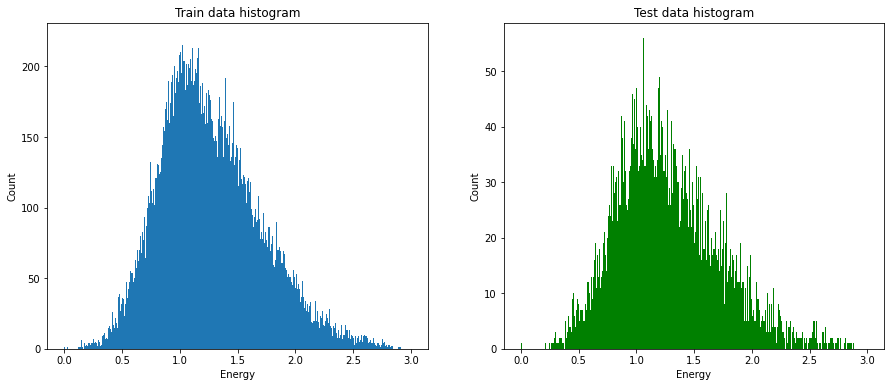

In [26]:
from matplotlib import pyplot as plt
import numpy as np 
from numpy import genfromtxt


energies_train = genfromtxt('output_train/energies.csv', delimiter=',')
energies_test = genfromtxt('output_test/energies.csv', delimiter=',')



f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

dat = energies_train[:,1]
mean_dat = np.mean(dat)
mean_var = np.var(dat)
print(mean_dat, np.sqrt(mean_var))
ax1.hist(dat, bins = np.arange(0.0, 3.0, 0.004)) 
#ax1.hist(dat)
ax1.set_title("Train data histogram") 
ax1.set_xlabel('Energy')
ax1.set_ylabel('Count')

dat = energies_test[:,1]
mean_dat = np.mean(dat)
mean_var = np.var(dat)
print(mean_dat, np.sqrt(mean_var))
ax2.hist(dat, bins = np.arange(0.0, 3.0, 0.004), color='green') 
#ax1.hist(dat)
ax2.set_title("Test data histogram") 
ax2.set_xlabel('Energy')
ax2.set_ylabel('Count')

#show the plots
plt.savefig('JEM_hist_energy.png')
plt.show()